## **Problem Set 2: Hydrological Extremes**
### **Due: Tuesday, January 30**

### **Setup**

**Please log into your Stanford Google Drive account when viewing this notebook.** Log in using your SUNetID credentials.

Before we can start Problem Set 2, we need to go through a few minor tasks, as we did in Problem Set 1:
1. Copy Google Colab Notebook (File > Save a copy in Drive)
2. Connect to Github Data Repo
3. Set Up Working Directory

The detailed instructions for the above tasks were provided in Problem Set 1, so we don't need to go through them again here. If you need assistance with any of the above tasks, please refer to Problem Set 1. We'll simply implement Tasks 2 and 3 in the code cell below. In addition, we'll also import all of the libraries we need to complete Problem Set 2.

In [1]:
# Clone github data repository
!git clone https://github.com/sfletcher23/CEE_266F_Data_Repo GitRepo

# set up working directory
import os
wdir = 'GitRepo/Data'
os.chdir(wdir)

# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as ss
from scipy.optimize import brentq as root
from math import gamma as GammaFN
from scipy.optimize import fsolve

Cloning into 'GitRepo'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 79 (delta 29), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (79/79), 786.99 KiB | 3.86 MiB/s, done.
Resolving deltas: 100% (29/29), done.


### **Problem 1**: Flood Occurrence Probabilities

Following up on the Lecture 10 slides, what is probability that a 100-year flood will occur during at least one year in a 10-year period? At least two years? Assume independence across years. Do you think the assumption of independence makes sense under this scenario? Briefly describe why or why not (no more than three sentences). (20 pts)


There should be a correlation between flooding occurrences in different years; If an area experienced flooding in the previous year, the likelihood of flooding in the upcoming year should be higher.
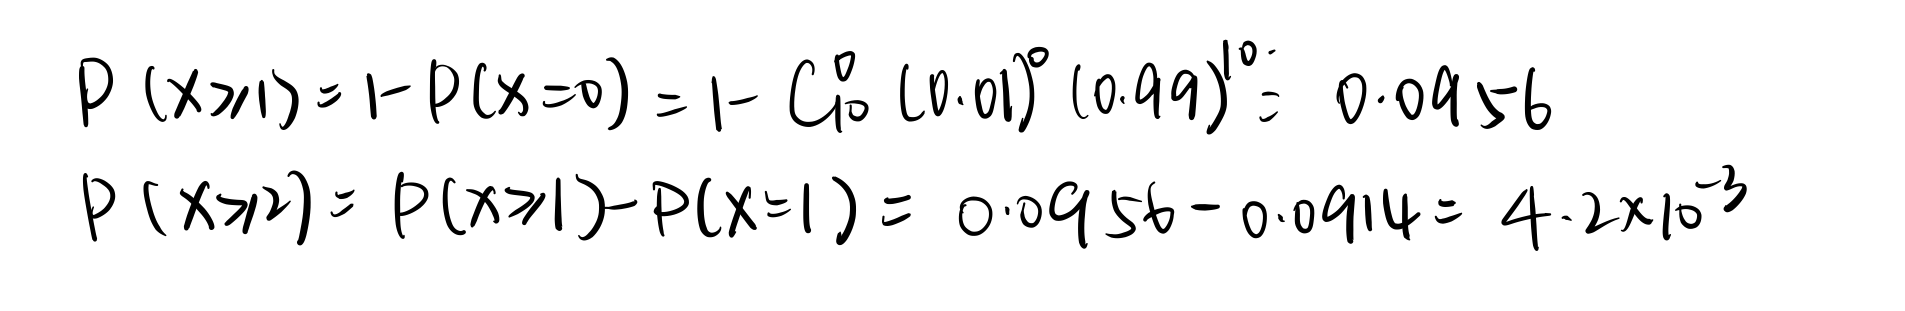

### **Problem 2**: Flood Frequency Assessment of the Assabet River


For this problem, use the entire record of daily streamflow data for the Assabet River in Maynard, MA from USGS (downloaded for you in "Assabet_MaynardMA.csv") to assess flood frequency. Starter code to load in and pre-process the dataset has been provided below.

In [2]:
# load data of daily flows on the Assabet River in Maynard, MA
allQ = pd.read_csv('Assabet_MaynardMA.csv')

# convert first column to date
allQ['Date'] = pd.to_datetime(allQ['Date'])
allQ['Flow'] = pd.to_numeric(allQ['Flow'],errors='ignore')

# find year of each data point
allQ['Year'] = allQ['Date'].dt.year

**Part A**: Calculate and plot the annual maxima from the daily streamflow data. (5 pts)

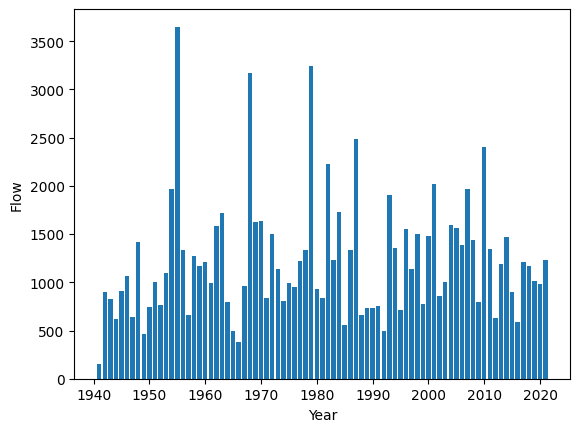

In [3]:
# Part A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

allQ

unique_years = allQ['Year'].unique()
annual_max=[]

for i in range(len(unique_years)):
  filtered_flow = allQ[allQ['Year'] == unique_years[i]]
  max_flow = max(filtered_flow['Flow'])
  annual_max.append(max_flow)

plt.bar(unique_years,annual_max)
plt.xlabel('Year')
plt.ylabel('Flow')
plt.show()




**Part B**: Fit a Gumbel distribution to the annual maxima using both MOM and MLE. Report the parameter estimates, 100-yr and 500-yr flood estimates. (5 pts)

In [5]:
# Part B
import scipy.stats as ss

def gumbel_r_mom(x):
    scale = np.sqrt(6)/np.pi * np.std(x)
    loc = np.mean(x) - 0.5772 * scale
    return loc, scale

[loc_mle,scale_mle] = ss.gumbel_r.fit(annual_max)
[loc_mom,scale_mom] = gumbel_r_mom(annual_max)

print(f"MLE parameters: loc: {loc_mle}; scale: {scale_mle}")
print(f"MOM parameters: loc: {loc_mom}; scale: {scale_mom}")

Y_100 = loc_mle-scale_mle*np.log(-np.log(0.99))
Y_500 = loc_mle-scale_mle*np.log(-np.log(0.998))
print("100-year Flood Estimate:",Y_100)
print("500-year Flood Estimate:",Y_500)


MLE parameters: loc: 958.3173537537803; scale: 443.921835230484
MOM parameters: loc: 943.3571202013727; scale: 485.5084414262298
100-year Flood Estimate: 3000.4240408385313
500-year Flood Estimate: 3716.6732938289524


**Part C:** For the MLE Gumbel distribution, estimate a 95% confidence interval of the 100-year and 500-year floods using an analytical approach. How do the confidence intervals for the 100-year and 500-year flood compare and why? (10 pts)

In [6]:
# Part C
import statsmodels.api as sm



alpha = 443.921835230484
p_100 = 1-1/100
p_500 = 1-1/500

y_100 = -np.log(-np.log(p_100))
y_500 = -np.log(-np.log(p_500))

Var_100 = alpha**2*(1.11+0.52*y_100+0.61*y_100**2)/len(annual_max)
Var_500 = alpha**2*(1.11+0.52*y_500+0.61*y_500**2)/len(annual_max)

CI_100 = [Y_100-1.96*np.sqrt(Var_100), Y_100+1.96*np.sqrt(Var_100)]
CI_500 = [Y_500-1.96*np.sqrt(Var_500), Y_500+1.96*np.sqrt(Var_500)]

print("100-year Flood Estimate:", Y_100, "with CI:", CI_100)
print("500-year Flood Estimate:", Y_500, "with CI:", CI_500)
print("500-year Flood has a wider confidence interval because 500-year flood has a larger variance due to its extreme nature")

100-year Flood Estimate: 3000.4240408385313 with CI: [2608.789331181011, 3392.0587504960513]
500-year Flood Estimate: 3716.6732938289524 with CI: [3206.0931755939164, 4227.253412063988]
500-year Flood has a wider confidence interval because 500-year flood has a larger variance due to its extreme nature


**Part D**: Using a threshold of 1,200 cfs, identify peaks over the threshold and remove peaks within 5 days of each other, keeping only the maximum. We have provided starter code that performs this task. Next, plot the identified peaks (along with the rest of the data) on a bar plot using a different color than the rest of the data. (5 pts)

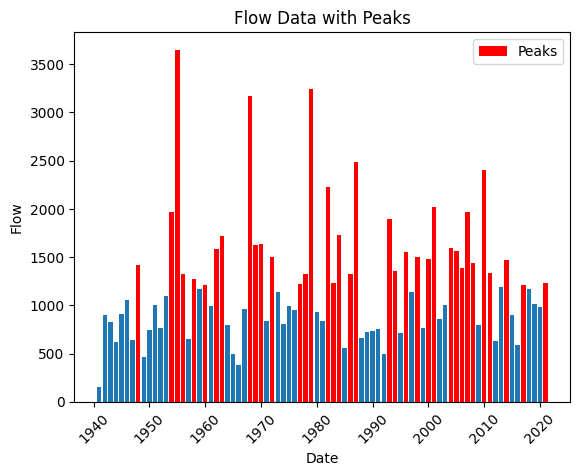

In [30]:
# Part D

# find all peaks over the threshold
x0 = 1200 # this value is a placeholder
peak_indices = np.where(allQ['Flow'] > x0)[0]

# find only independent peaks
# if more than 1 peak over the threshold within 5 days of each other, pick only the largest
def findClusters(indices):
    allClusters = []
    subCluster = [indices[0]]
    for i in range(1,len(indices)):
        if indices[i] - subCluster[-1] <= 5:
            subCluster.append(indices[i])
        else:
            allClusters.append(subCluster)
            subCluster = [indices[i]]

    allClusters.append(subCluster)

    return allClusters

# Updated find peaks function to get dates of peaks
def findPeaks(clusters, data, dataTime):
    peaks = np.zeros(len(clusters))
    dates = []

    for i in range(len(peaks)):
        peaks[i] = np.max(data[clusters[i]])
        ind = np.where(peaks[i] == data[clusters[i]])[0][0]
        dates.append(dataTime[clusters[i][ind]])
    return peaks, dates

# find clusters
clusters = findClusters(peak_indices)
peaks = findPeaks(clusters, allQ['Flow'], allQ['Date'])
years = [date.year for date in peaks[1]]
plt.bar(allQ['Year'],allQ['Flow'])
plt.bar(years, peaks[0], color='red', label='Peaks')
plt.xlabel('Date')
plt.ylabel('Flow')
plt.title('Flow Data with Peaks')
plt.legend()
plt.xticks(rotation=45)
plt.show()



**Part E**: Estimate the Poisson arrival rate of floods over the threshold and interpret this value. (5 pts)

In [31]:
# Part E
lamb = len(peak_indices)/len(allQ['Flow'])
print(" The lambda", lamb,"refers to the succuess rate which means during unit time period, there exist lambda floods over the threshold.")
print(" The 1/lambda", 1/lamb, "refers two the time interval between two successful events.")


 The lambda 0.00539028384279476 refers to the succuess rate which means during unit time period, there exist lambda floods over the threshold.
 The 1/lambda 185.51898734177215 refers two the time interval between two successful events.


**Part F**: Fit a Generalized Pareto (GP) distribution (using the starter code provided) to the remaining peaks over the threshold. Report the parameter estimates and interpret the results. (5 pts)

In [32]:
# Part F

# define function to calculate moments
def findMoments(data):

    xbar = np.mean(data)
    std = np.std(data, ddof=1)
    skew = ss.skew(data,bias=False)

    return xbar, std, skew

# define function to fit a Generalized Pareto distribution
def fitGPD(data, x0, method, initialize=False):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"

    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        if initialize == True:
            kappa = 0.5*(((xbar-x0)/std)**2-1)
            kappa, x0, alpha = ss.genpareto.fit(data, kappa, floc=x0)
        else:
            kappa, x0, alpha = ss.genpareto.fit(data, floc=x0)
    elif method == 'MOM':
        kappa = 0.5*(((xbar-x0)/std)**2-1)
        alpha = (1+kappa)*(xbar - x0)

    return kappa, x0, alpha

kappa_mle,x0_mle,alpha_mle = fitGPD(peaks[0],1200,"MLE")
print("kappa =", kappa_mle)
print("x0 =", x0_mle)
print("alpha =", alpha_mle)
print("Interpretation: The alpha controls the wide of the distribution and the kappa controls the steepness of the distribution.")

kappa = 0.2440254462640908
x0 = 1200
alpha = 331.17693922873195
Interpretation: The alpha controls the wide of the distribution and the kappa controls the steepness of the distribution.


### **Problem 3**: USGS StreamStats Tool

Use the [USGS StreamStats tool](https://streamstats.usgs.gov/ss/) to obtain another estimate for the 100-year and 500-year floods at the USGS gage site. Specifically:

**Part A**: What are the StreamStats estimates for the 100-year and 500-year floods at the site of the Assabet River (USGS gage no. 01097000)?

Start by putting the geographic coordinates for the USGS gage into the search box, and then go to the StreamStats Gage page from the gaging station icon (blue triangle).

Hint: The 100-year flood is the same as the 1-percent annual exceedance probability (AEP) flood.) (5 pts)

**Answer:** According to the website, the 1-percent AEP is 3954 cubic feet per second. The 0.2-percent AEP is 5444 cubic feet per second.

**Part B**: What method was used to obtain this estimate? (Hint: look at the [documentation](https://pubs.usgs.gov/sir/2016/5156/sir20165156.pdf), pages 7-8.) (5 pts)

**Answer:**
1. An initial analysis of annual peak flows at 153 streamgages throughout New England was conducted using the Expected Moments Algorithm (EMA) to determine the at-site skew.
2. The at-site skews determined from the initial analysis were used in a regional skew analysis to determine appropriate weighting for the at-site skew before computing the AEP flood flows at the streamgages.
3. The guidelines developed by the Interagency Committee on Water Data (1981) were followed, which recommend fitting annual peak flows to a log-Pearson type III distribution. The magnitude of floods for a given AEP was computed using the mean, standard deviation, skew, and a factor based on the skew and the given percent AEP.
4. An updated procedure similar to the one outlined by the Interagency Committee on Water Data (1981) was used, known as the EMA. The EMA accommodates interval data, perception thresholds, and censoring of multiple low outliers to better define the distribution characteristics of annual peak flows.
5. Adjustments were made for low outliers in the peak flow records using a modified version of the Grubbs-Beck test developed by Cohn and others (2013), referred to as the multiple Grubbs-Beck test (MGBT).
Low outliers and potentially influential low flows (PILFs) were detected and conditioned using the EMA analysis.

**Part C**: What are some pros and cons of the methods you used in Questions 2 Part B compared to the methods used by USGS in Question 3 Part B? (5 pts)

**Answer:**
In Question 2 part B, I used MOM and MLE to fit the annual maxima to Gumbel distribution.
Pros: The method is straightforward to implement and understand. It identifies the single highest value observed each year, providing a clear picture of the most extreme event for each period.
Cons: The method only captures the single highest value observed each year, potentially missing other significant events that fall below this maximum.Extreme outliers in any given year can disproportionately influence the estimated extreme value distribution, leading to potential inaccuracies.

### **Problem 4**: 7Q10 Flow Analysis of the Assabet River

Using the flow data from the Assabet River at Maynard, compute the annual minimum 7-day flows and fit them to the following distributions:
1. 2-parameter lognormal using MOM
2. 2-parameter lognormal using MLE
3. 2-parameter Weibull using MOM
4. 2-parameter Weibull using MLE

We have provided a function that can be used to fit a Weibull distribution in the starter code.

Report the parameter values and 7Q10 for each fit. (20 pts)

Apply the K-S test to these distributions. What are your findings? (10 pts)

Lognormal with MLE parameters:
Shape: 0.7568047663704487
Location: 0
Scale: 121.49669638858518

Lognormal with MOM parameters:
Shape: 0.5326895485257633
Scale: 130.35625401747376

Weibull with MLE parameters:
Shape: 1.7820802749333038
Location: 0
Scale: 168.31341377663304

Weibull with MOM parameters:
Shape: 1.7948059536995238
Location: 0
Scale: 168.9063531952671

7Q10 of Lognormal distribution with MLE: 46.06266440151611
7Q10 of Lognormal distribution with MOM: 65.86465752513737
7Q10 of Weibull distribution with MLE: 47.61045071680403
7Q10 of Weibull distribution with MOM: 48.20787367635269

K-S Test for Lognormal distribution with MLE: KstestResult(statistic=0.14506498737416273, pvalue=0.05961483556416669, statistic_location=94.0, statistic_sign=-1)
K-S Test for Lognormal distribution with MOM: KstestResult(statistic=0.08055273665179641, pvalue=0.6396624491928398, statistic_location=149.0, statistic_sign=-1)
K-S Test for Weibull distribution with MLE: KstestResult(statistic=0.0763839

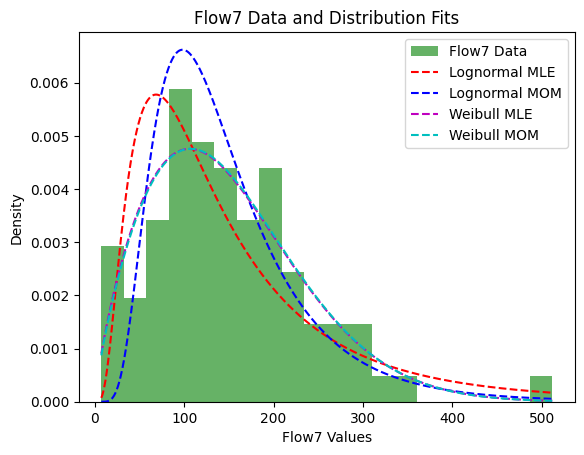

In [39]:
# Problem 4

# Fit a Weibull distribution. Note if you want the two-parameter Weibull, you have to set npars=2
def fitWeibull(data, method, npars):
    assert method == 'MLE' or method == 'MOM',"method must = 'MLE' or 'MOM'"
    assert npars == 2 or npars == 3,"npars must = 2 or 3"

    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        if npars == 2:
            kappa, xi, alpha = ss.weibull_min.fit(data,floc=0)
        elif npars == 3:
            kappa, xi, alpha = ss.weibull_min.fit(data)
    elif method == 'MOM':
        if npars == 2:
            kappa = root(lambda x: xbar**2 * (GammaFN(1+2/x)/GammaFN(1+1/x)**2 -1) - std**2, 0.02, 10)
            alpha = xbar / GammaFN(1+1/kappa)
            xi = 0
        elif npars == 3:
            def equations(p):
                kappa, xi, alpha = p
                mu = alpha*GammaFN(1+1/kappa) + xi
                sigma = np.sqrt(alpha**2*(GammaFN(1+2/kappa)-(GammaFN(1+1/kappa))**2))
                gamma = (GammaFN(1+3/kappa)*alpha**3 -3*mu*sigma**2 - mu**3)/(sigma**3)
                return (mu-xbar, sigma-std, gamma-skew)

            kappa = root(lambda x: xbar**2 * (GammaFN(1+2/x)/GammaFN(1+1/x)**2 -1) - std**2, 0.02, 10)
            alpha = xbar / GammaFN(1+1/kappa)
            xi = 0
            kappa, xi,alpha = fsolve(equations,(kappa,xi,alpha))

    return kappa, xi, alpha


unique_years = allQ['Year'].unique()
Flow_7 = [0] * len(unique_years)
for n in range(len(unique_years)):
  X = allQ[allQ['Year'] == unique_years[n]]['Flow']
  Flow_7_all = [0] * (len(X) - 6)
  for i in range(6, len(X)):
    Flow_7_all[i - 6] = sum(X[i - 6 : i + 1])
  Flow_7[n] = min(Flow_7_all)

# lognormal with MLE
s_MLE_log, loc_MLE_log, scale_MLE_log = ss.lognorm.fit(Flow_7, floc=0)

# lognormal with MOM
mean_X = np.mean(Flow_7)
std_X = np.std(Flow_7)
s_MOM_log = np.sqrt(np.log(1 + (std_X / mean_X) ** 2))
mu_hat = np.log(mean_X) - 0.5*(np.log(1 + (std_X / mean_X) ** 2))
scale_MOM_log = np.exp(mu_hat)

# Weibull with MLE
s_MLE_wb, loc_MLE_wb, scale_MLE_wb = fitWeibull(Flow_7,'MLE',2)

# Weibull with MOM
s_MOM_wb, loc_MOM_wb, scale_MOM_wb = fitWeibull(Flow_7,'MOM',2)


# Lognormal distribution with MLE
percentile_lognorm_MLE = ss.lognorm.ppf(0.1, s_MLE_log, loc=loc_MLE_log, scale=scale_MLE_log)

# Lognormal distribution with MOM
percentile_lognorm_MOM = ss.lognorm.ppf(0.1, s_MOM_log, loc=0, scale=scale_MOM_log)

# Weibull distribution with MLE
percentile_weibull_MLE = ss.weibull_min.ppf(0.1, s_MLE_wb, loc=loc_MLE_wb, scale=scale_MLE_wb)

# Weibull distribution with MOM
percentile_weibull_MOM = ss.weibull_min.ppf(0.1, s_MOM_wb, loc=loc_MOM_wb, scale=scale_MOM_wb)

print("Lognormal with MLE parameters:")
print("Shape:", s_MLE_log)
print("Location:", loc_MLE_log)
print("Scale:", scale_MLE_log)

print("\nLognormal with MOM parameters:")
print("Shape:", s_MOM_log)
print("Scale:", scale_MOM_log)

print("\nWeibull with MLE parameters:")
print("Shape:", s_MLE_wb)
print("Location:", loc_MLE_wb)
print("Scale:", scale_MLE_wb)

print("\nWeibull with MOM parameters:")
print("Shape:", s_MOM_wb)
print("Location:", loc_MOM_wb)
print("Scale:", scale_MOM_wb)

print("\n7Q10 of Lognormal distribution with MLE:", percentile_lognorm_MLE)
print("7Q10 of Lognormal distribution with MOM:", percentile_lognorm_MOM)
print("7Q10 of Weibull distribution with MLE:", percentile_weibull_MLE)
print("7Q10 of Weibull distribution with MOM:", percentile_weibull_MOM)

# K-S Test
# K-S test for Lognormal distribution with MLE
ks_test_lognorm_MLE = ss.kstest(Flow_7, 'lognorm', args=(s_MLE_log, loc_MLE_log, scale_MLE_log))

# K-S test for Lognormal distribution with MOM
ks_test_lognorm_MOM = ss.kstest(Flow_7, 'lognorm', args=(s_MOM_log, 0, scale_MOM_log))

# K-S test for Weibull distribution with MLE
ks_test_weibull_MLE = ss.kstest(Flow_7, 'weibull_min', args=(s_MLE_wb, loc_MLE_wb, scale_MLE_wb))

# K-S test for Weibull distribution with MOM
ks_test_weibull_MOM = ss.kstest(Flow_7, 'weibull_min', args=(s_MOM_wb, loc_MOM_wb, scale_MOM_wb))

print("\nK-S Test for Lognormal distribution with MLE:", ks_test_lognorm_MLE)
print("K-S Test for Lognormal distribution with MOM:", ks_test_lognorm_MOM)
print("K-S Test for Weibull distribution with MLE:", ks_test_weibull_MLE)
print("K-S Test for Weibull distribution with MOM:", ks_test_weibull_MOM)
print(Flow_7)

plt.hist(Flow_7, bins=20, density=True, alpha=0.6, color='g', label='Flow7 Data')
x = np.linspace(min(Flow_7), max(Flow_7), 1000)
pdf_log_MLE = ss.lognorm.pdf(x, s_MLE_log, loc=loc_MLE_log, scale=scale_MLE_log)
plt.plot(x, pdf_log_MLE, 'r--', label='Lognormal MLE')
pdf_log_MOM = ss.lognorm.pdf(x, s_MOM_log, loc=0, scale=scale_MOM_log)
plt.plot(x, pdf_log_MOM, 'b--', label='Lognormal MOM')
pdf_wb_MLE = ss.weibull_min.pdf(x, s_MLE_wb, loc=loc_MLE_wb, scale=scale_MLE_wb)
plt.plot(x, pdf_wb_MLE, 'm--', label='Weibull MLE')
pdf_wb_MOM = ss.weibull_min.pdf(x, s_MOM_wb, loc=loc_MOM_wb, scale=scale_MOM_wb)
plt.plot(x, pdf_wb_MOM, 'c--', label='Weibull MOM')

plt.xlabel('Flow7 Values')
plt.ylabel('Density')
plt.title('Flow7 Data and Distribution Fits')
plt.legend()

**Findings:** The p-value of lognormal distribution with MLE is small, which means I can reject null hypothesis. Samples does not come from the lognormal distribution with MLE method. The p-value of MOM is larger than that of MLE since MOM estimates parameters by matching sample moments to population moments.

## **End of Problem Set  2**

**Important Notes on handing in your problem set:**

1. Please save your Google Colab notebook as a PDF by navigating to File > Print > Print to PDF. Next, hand in your assignment by uploading your pdf to Gradescope. You may notice that the formatting of your notebook is not retained when exporting as a PDF in this way. An alternative method of exporting your notebook as a PDF in a way that retains formatting is following Method 1 from this [video tutorial](https://www.youtube.com/watch?v=-Ti9Mm21uVc).
2. To help with grading, please make sure your Google Collab Notebook is shared (with edit access) with Mofan (mofanz@stanford.edu) and Aniket (aniketv@stanford.edu). In addition, please include the full link of your notebook here: {}.